Importing the relevant libraries & Modules

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [ ]:
#! pip install -q kaggle

In [ ]:
# Mounting to google drive


 Dataset loading procedure from Kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!pwd

/content


In [ ]:
!cp /content/drive/MyDrive/Portfolio_Projects/Potato_Disease_Classification/kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Code fro downloading the competitions data from kaggle
!kaggle datasets download arjuntejaswi/plant-village


Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 96% 317M/329M [00:01<00:00, 211MB/s]
100% 329M/329M [00:01<00:00, 199MB/s]


In [ ]:
!unzip /content/plant-village.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: PlantVillage/Tomato__Tomato_YellowLeaf__Cur

## Deleting unnecessary dataset

In [ ]:
import os
import shutil

# List of folders you want to keep
folders_to_keep = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Source directory where the dataset is extracted
source_dir = '/content/PlantVillage'

# Get the list of all folders in the source directory
all_folders = os.listdir(source_dir)

# Delete folders that are not in the list of folders to keep
for folder in all_folders:
    if folder not in folders_to_keep:
        folder_path = os.path.join(source_dir, folder)
        if os.path.isdir(folder_path):
            shutil.rmtree(folder_path)

print("Unneeded folders have been deleted, keeping only the specified folders.")


Unneeded folders have been deleted, keeping only the specified folders.


## Just a observation about the image size

In [ ]:
# Just a observation about the image size
Path = '/content/PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG'
import numpy as np
from PIL import Image
img = Image.open(Path)
img = np.array(img)
print(img.shape)

(256, 256, 3)


## Creating TF.data.dataset

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset.file_paths)

2152

## Some Interesting Observations

In [ ]:
len(dataset) # It is equal to Number of batches i.e. (total_files)/(BATCH_SIZE)

68

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

###  Displaying  an Image

Potato___Early_blight


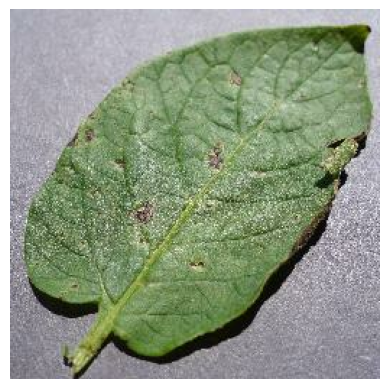

In [ ]:
for image_batch, label_batch in dataset.take(1):
  #print(image_batch.shape)
  # trying to show one image
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  # Printing the class name Instead of Labl number
  # print(label_batch[0].numpy())
  print(class_name[label_batch[0].numpy()])
  plt.axis("off")

### Displaying more than one image


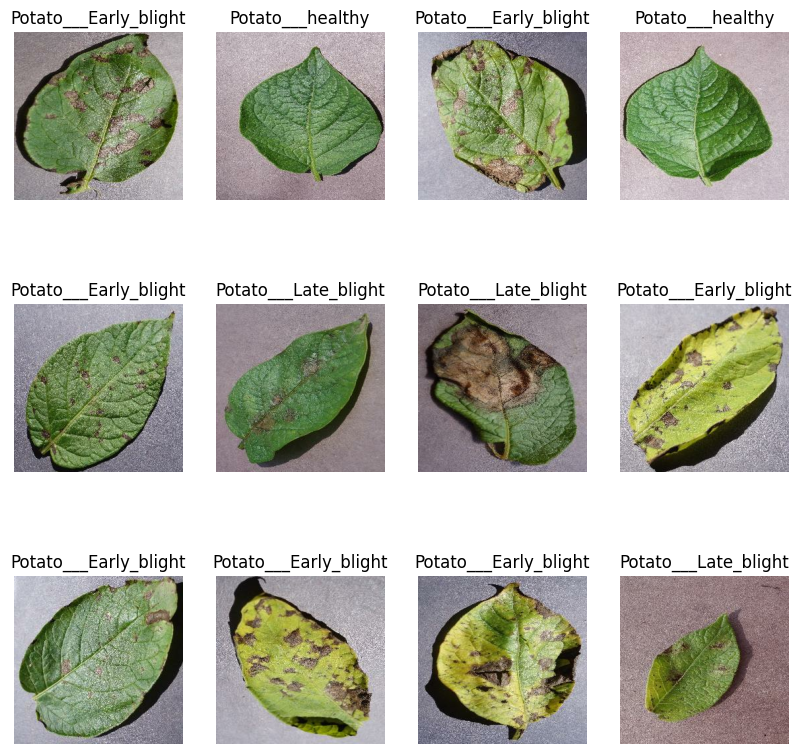

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_name[label_batch[i]])
    plt.axis("off")

## Train Test Splitting

In [ ]:
# 80% ==> Training datsaet
# 10% ==> Validation Dataset ; 10% ==> test dataset

In [ ]:
train_size = 0.8
train_size = int(len(dataset)*train_size)
train_size

54

In [ ]:
train_ds = dataset.take(train_size)
len(train_ds)

54

In [ ]:
combined_ds = dataset.skip(train_size)
len(combined_ds)

14

In [ ]:
val_comp = 0.1
val_size = int(len(dataset)*val_comp)
val_size

val_ds = combined_ds.take(val_size)
len(val_ds)


6

In [ ]:
test_ds = combined_ds.skip(val_size)
len(test_ds)

8

## Wrapping all the steps in function

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(train_ds)


54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)



8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the model

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/20
54/54 [==============================] - 241s 4s/step - loss: 0.8803 - accuracy: 0.5150 - val_loss: 0.7293 - val_accuracy: 0.6510
Epoch 2/20
54/54 [==============================] - 235s 4s/step - loss: 0.6079 - accuracy: 0.7245 - val_loss: 0.5472 - val_accuracy: 0.7604
Epoch 3/20
54/54 [==============================] - 236s 4s/step - loss: 0.3964 - accuracy: 0.8293 - val_loss: 0.2993 - val_accuracy: 0.9115
Epoch 4/20
54/54 [==============================] - 234s 4s/step - loss: 0.2532 - accuracy: 0.9057 - val_loss: 0.1684 - val_accuracy: 0.9271
Epoch 5/20
54/54 [==============================] - 238s 4s/step - loss: 0.2198 - accuracy: 0.9126 - val_loss: 0.1350 - val_accuracy: 0.9375
Epoch 6/20
54/54 [==============================] - 235s 4s/step - loss: 0.1618 - accuracy: 0.9288 - val_loss: 0.2641 - val_accuracy: 0.8854
Epoch 7/20
54/54 [==============================] - 242s 4s/step - loss: 0.1553 - accuracy: 0.9427 - val_loss: 0.1108 - val_accuracy: 0.9635
Epoch 8/20
54

In [ ]:
SCORES = model.evaluate(test_ds)

8/8 [==============================] - 15s 1s/step - loss: 0.0591 - accuracy: 0.9844


In [ ]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history.keys())

dict_keys

In [ ]:
Acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']


In [ ]:
EPOCHS = 20

Text(0.5, 1.0, 'Training and Validation loss')

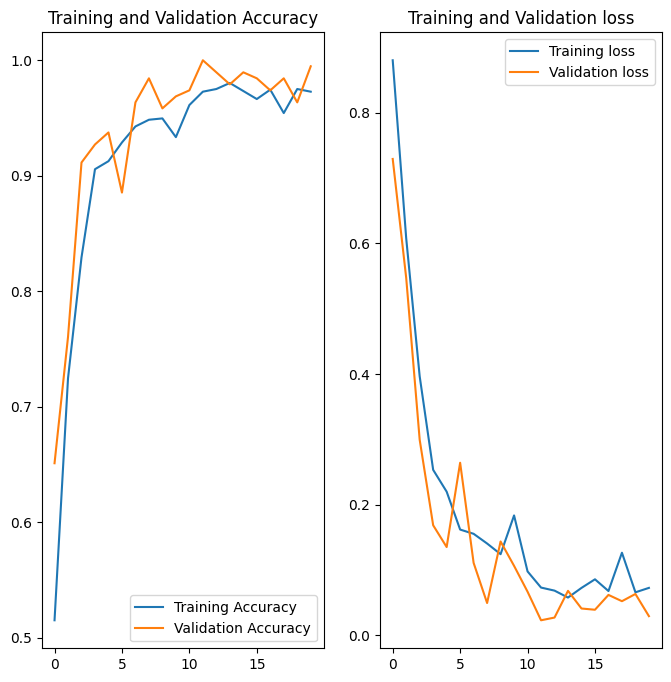

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),Acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation loss')
plt.legend(loc= 'upper right')
plt.title('Training and Validation loss')

In [ ]:
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


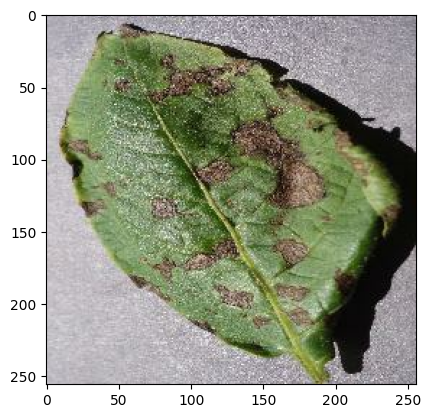

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
path = '/content/drive/MyDrive/Portfolio_Projects/Potato_Disease_Classification'
model_path = os.path.join(path, "../models")
os.mkdir(model_path)

In [ ]:

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
print(model_version)
model.save(f"{model_path}{model_version}")

1


In [ ]:
# Changing the directory to model
os.getcwd()

'/content'